## Title : Mobile Price Classification

## Introduction: Mobile Price Classification

The smartphone market is growing quickly, with many phones available at different prices. For phone companies, deciding the right price for each model is important. The Mobile Price Classification dataset from Kaggle helps us learn how to use machine learning to predict the price range of a mobile phone based on its features. The dataset includes 2,000 phones with 20 technical features like battery power, RAM, camera quality, internal storage, screen size, and whether it supports 3G or 4G. Each phone is labeled with a price range from 0 to 3  where 0 means low cost and 3 means very high cost.

In this project, we explore the data and train different machine learning models such as Decision Tree, KNN, Random Forest, Naive Bayes, and Logistic Regression. We compare how well each model works by checking accuracy, precision, recall, and F1 score. We also use PCA (Principal Component Analysis) to reduce the number of features and see if that improves results. Finally, we use SHAP (SHapley Additive exPlanations) to understand which features affect the price the most. This project shows how machine learning can be used to help make smart decisions in product pricing.





## Step 1: Imports and Setup
We start by importing all necessary libraries and modules for data handling, visualization, preprocessing, modeling, and evaluation. We also set some styling for plots and suppress warnings for cleaner output.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

sns.set(style="whitegrid")
import warnings
warnings.filterwarnings("ignore")


## Step 2: Load Dataset
Load the dataset from the CSV file and check its shape and information (columns, data types, null values).

In [2]:
data = pd.read_csv("/kaggle/input/mobile-price-classification/train.csv")
print("Shape:", data.shape)
print(data.info())


Shape: (2000, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int

## Step 3: Exploratory Data Analysis (EDA)
Explore the dataset visually to understand the target variable distribution, feature distributions, presence of outliers, and feature correlations.

## 3.1 Target Variable Distribution

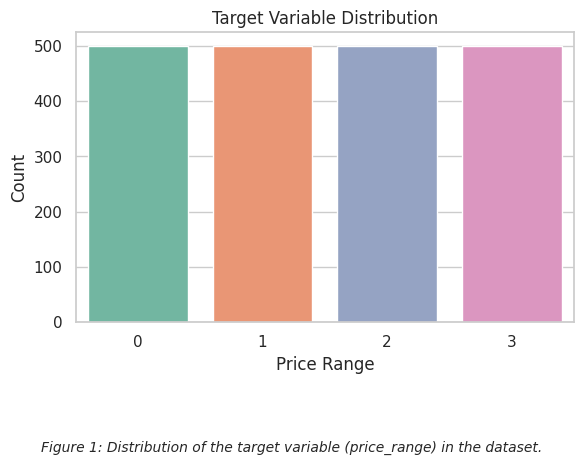

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.countplot(x='price_range', data=data, palette='Set2')
plt.title("Target Variable Distribution")
plt.xlabel("Price Range")
plt.ylabel("Count")

# Add centered figure caption in one line
plt.figtext(0.5, -0.15, 
            "Figure 1: Distribution of the target variable (price_range) in the dataset.", 
            wrap=True, horizontalalignment='center', fontsize=10, style='italic')

plt.tight_layout()
plt.show()


## 3.2 Feature Distributions (Histograms)

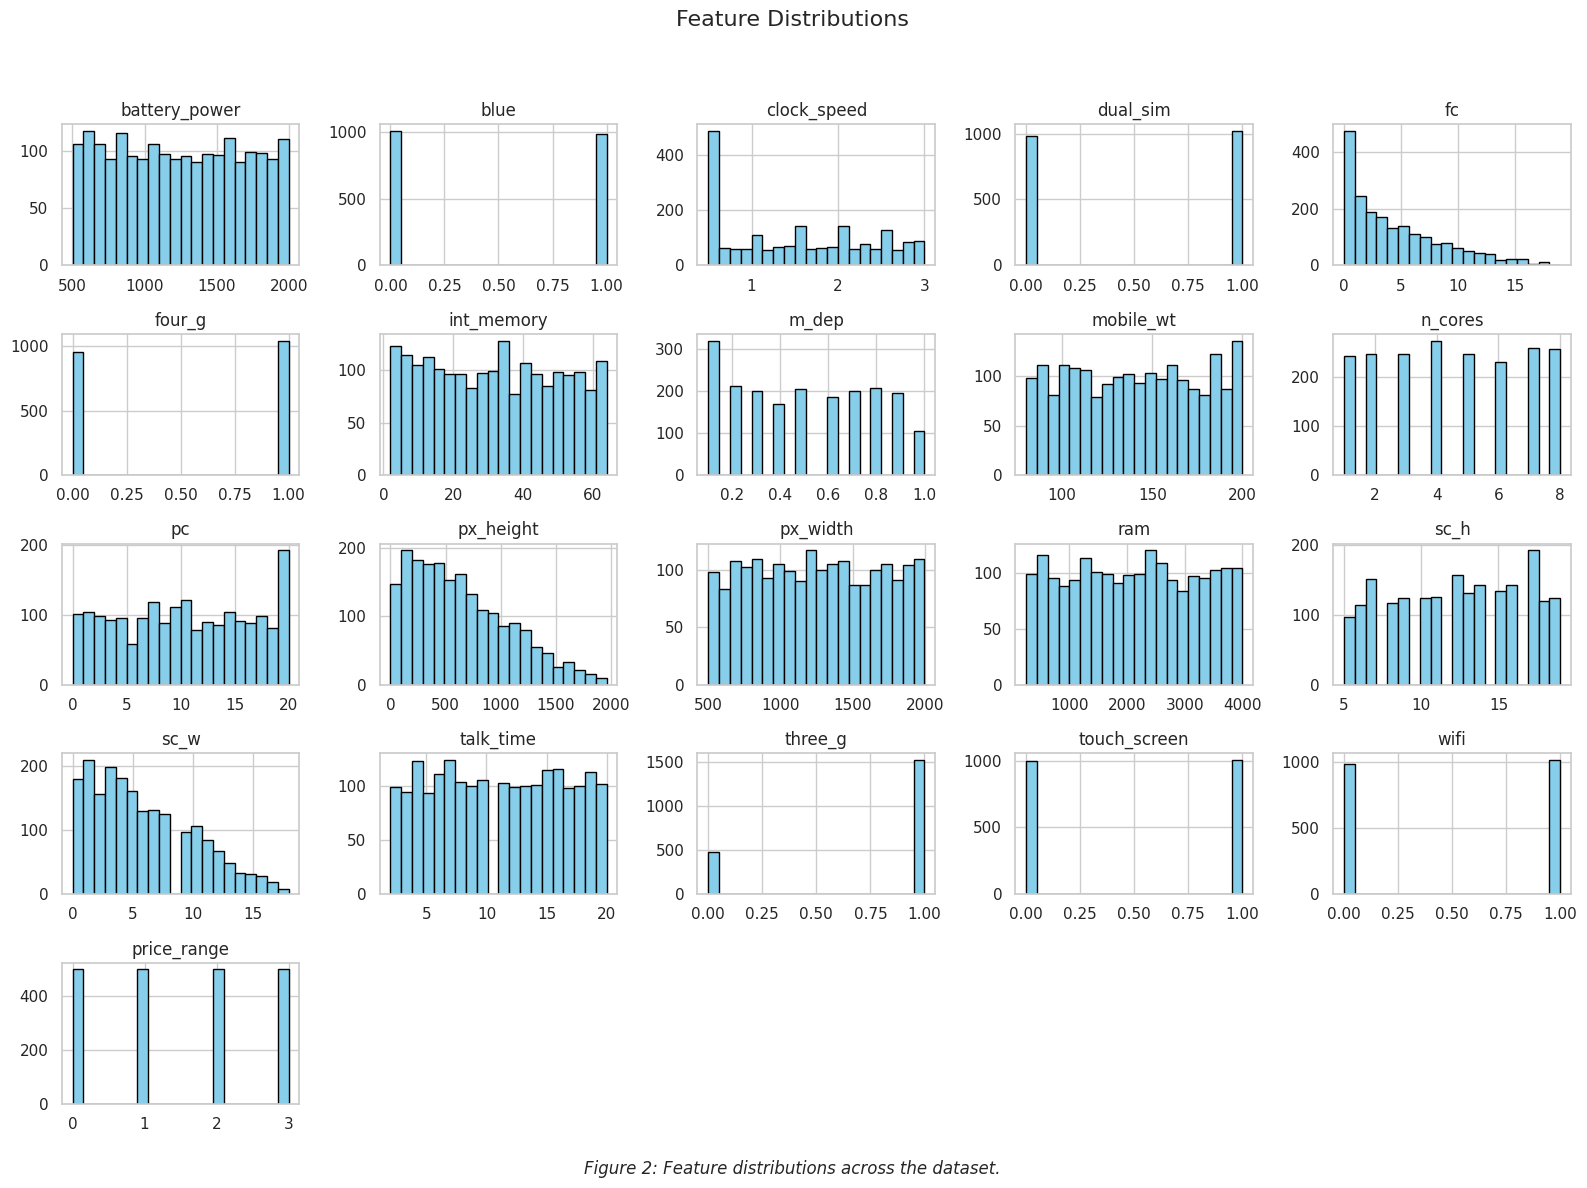

In [35]:
data.hist(bins=20, figsize=(16, 12), color='skyblue', edgecolor='black')
plt.suptitle('Feature Distributions', fontsize=16)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # leave space for suptitle

# Add APA-style centered figure caption below the plot
plt.figtext(0.5, 0.01, 
            "Figure 2: Feature distributions across the dataset.", 
            wrap=True, horizontalalignment='center', fontsize=12, style='italic')

plt.show()


## 3.3 Boxplots to Detect Outliers

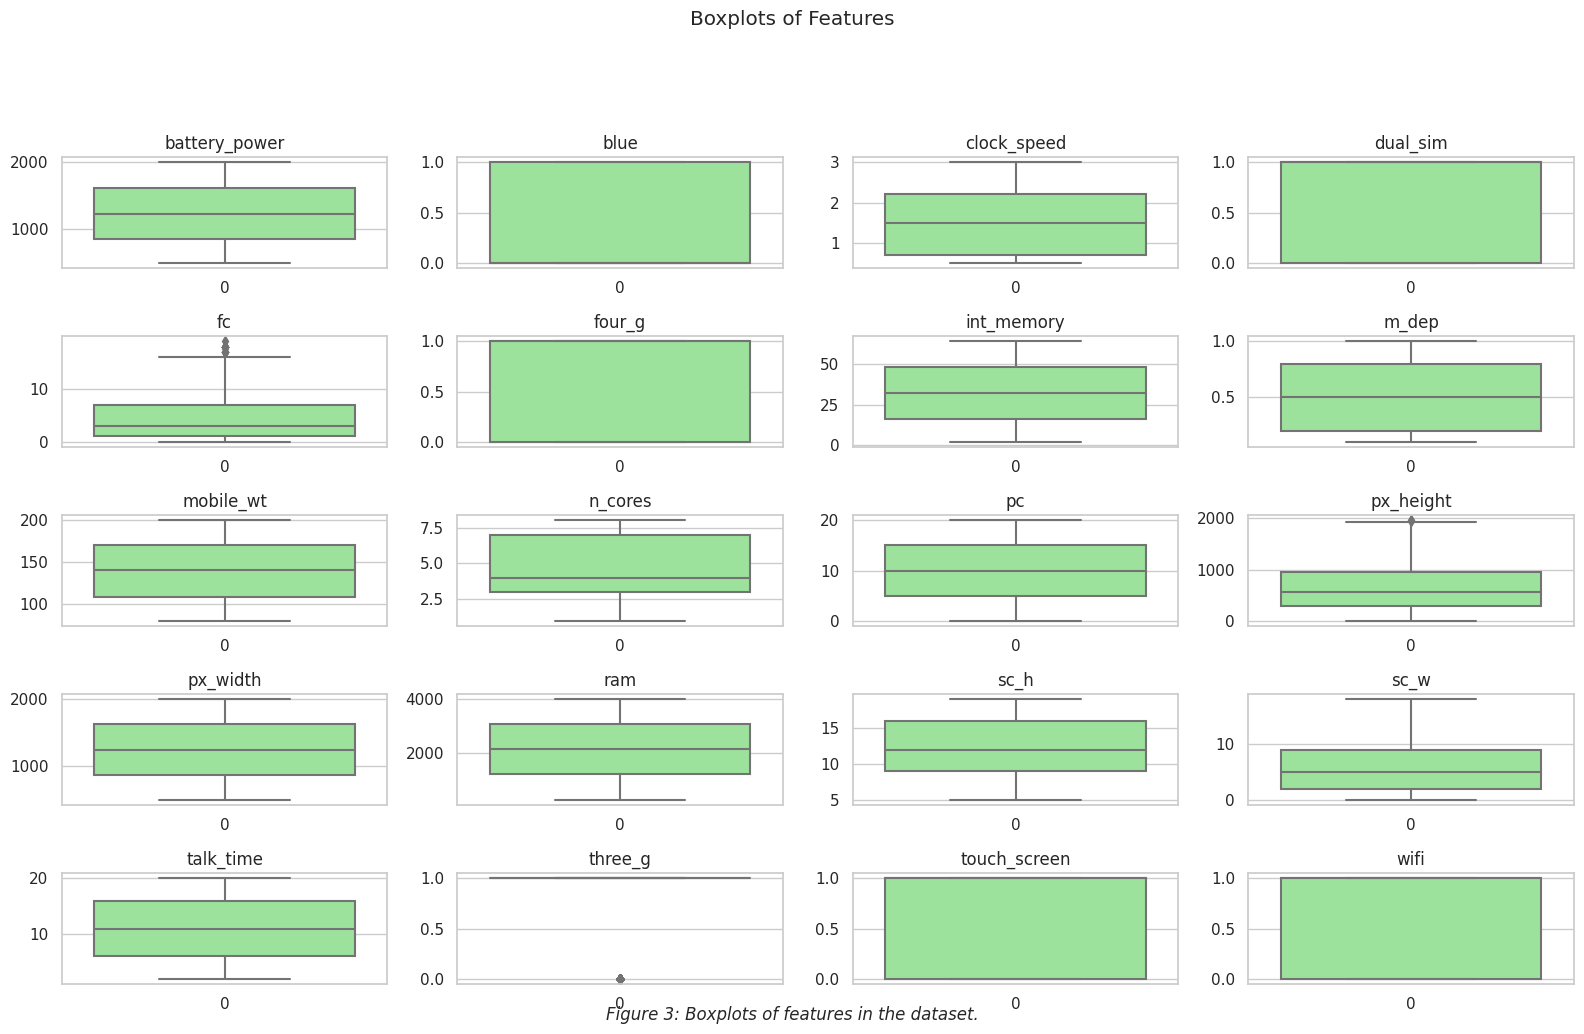

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 10))
for i, col in enumerate(data.columns[:-1]):
    plt.subplot(5, 4, i+1)
    sns.boxplot(data[col], color='lightgreen')
    plt.title(col)

plt.suptitle("Boxplots of Features", y=1.02)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for suptitle on top

# Add centered figure caption below the plots
plt.figtext(0.5, 0.01,
            "Figure 3: Boxplots of features in the dataset.",
            wrap=True, horizontalalignment='center', fontsize=12, style='italic')

plt.show()


## 3.4 Correlation Heatmap

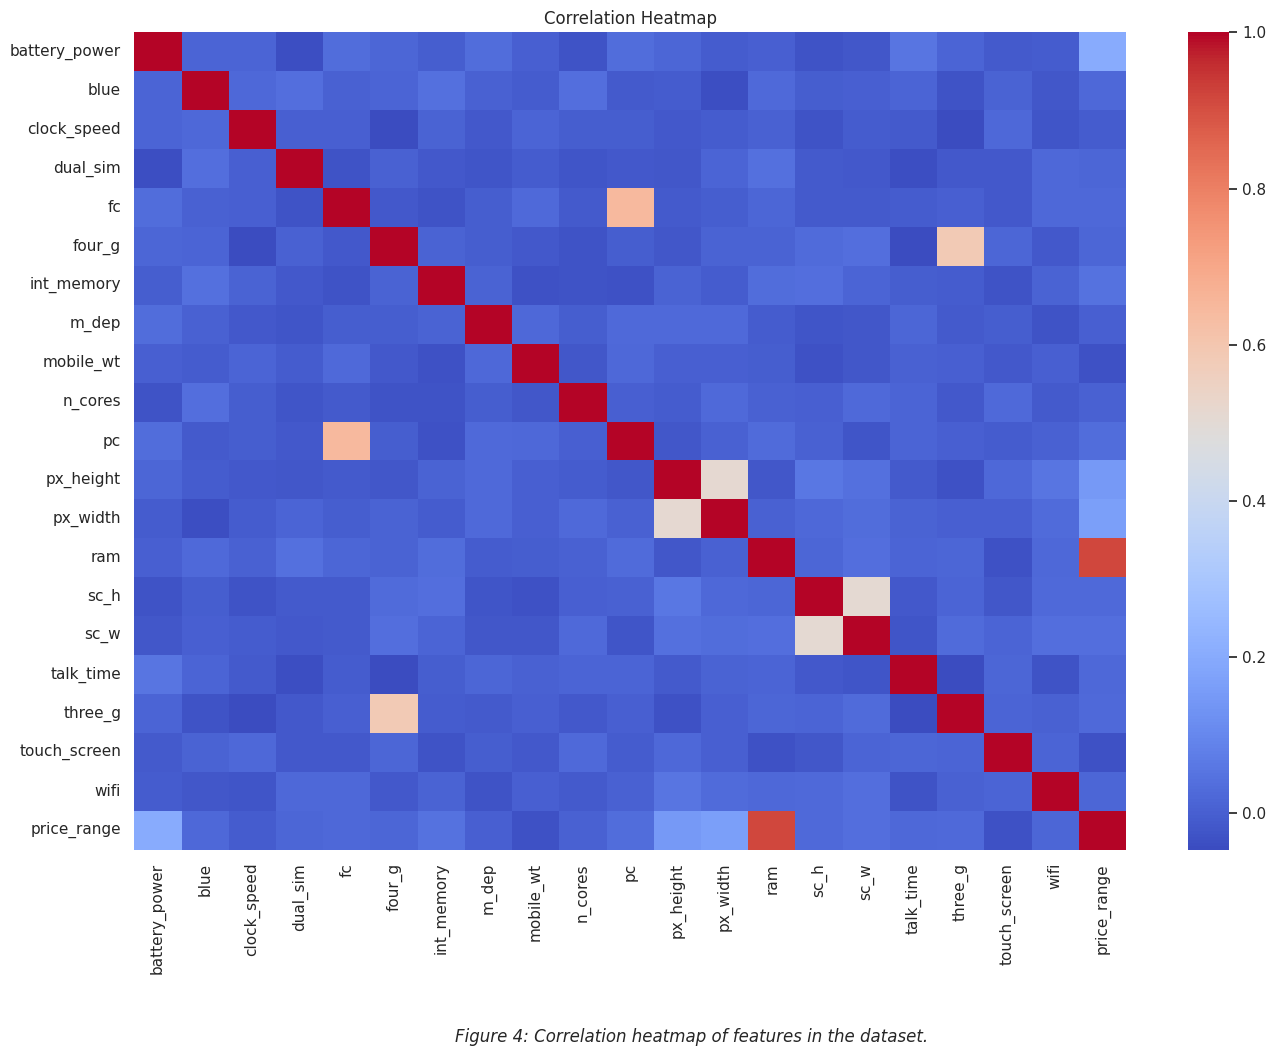

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 10))
sns.heatmap(data.corr(), cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap")

plt.tight_layout()

# Add centered figure caption below the plot
plt.figtext(0.5, -0.05,
            "Figure 4: Correlation heatmap of features in the dataset.",
            wrap=True, horizontalalignment='center', fontsize=12, style='italic')

plt.show()


## Step 4: Preprocessing
Split the dataset into training and testing sets, scale the features, and apply Principal Component Analysis (PCA) for dimensionality reduction.

In [7]:
X = data.drop("price_range", axis=1)
y = data["price_range"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


## Step 5: Define Models and Hyperparameters
Create a dictionary that holds the machine learning models and their respective hyperparameters for tuning.

In [8]:
model_defs = {
    "Decision Tree": {
        "model": DecisionTreeClassifier(random_state=42),
        "params": {"max_depth": [None, 5, 10], "min_samples_split": [2, 5]}
    },
    "KNN": {
        "model": KNeighborsClassifier(),
        "params": {"n_neighbors": [3, 5, 7], "weights": ['uniform', 'distance']}
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {"n_estimators": [50, 100], "max_depth": [None, 10]}
    },
    "Naive Bayes": {
        "model": GaussianNB(),
        "params": {}
    },
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000, solver='liblinear'),
        "params": {"C": [0.01, 0.1, 1, 10], "penalty": ["l1", "l2"]}
    }
}

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']


## Step 6: Model Evaluation Function
Define a function that:

Trains the model on original scaled data,

Performs hyperparameter tuning via GridSearchCV,

Applies the best model on PCA-reduced data,

Collects and returns evaluation metrics for all scenarios.

In [9]:
def evaluate_model(name, model, params):
    results = []

    # Original scaled data
    model.fit(X_train_scaled, y_train)
    pred = model.predict(X_test_scaled)
    results.append({
        "Scenario": "Original",
        "Accuracy": accuracy_score(y_test, pred),
        "Precision": precision_score(y_test, pred, average='weighted'),
        "Recall": recall_score(y_test, pred, average='weighted'),
        "F1 Score": f1_score(y_test, pred, average='weighted'),
        "Best Params": "default"
    })

    # Hyperparameter tuning on scaled data
    grid = GridSearchCV(model, params, cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train_scaled, y_train)
    pred = grid.predict(X_test_scaled)
    results.append({
        "Scenario": "Hypertuning",
        "Accuracy": accuracy_score(y_test, pred),
        "Precision": precision_score(y_test, pred, average='weighted'),
        "Recall": recall_score(y_test, pred, average='weighted'),
        "F1 Score": f1_score(y_test, pred, average='weighted'),
        "Best Params": grid.best_params_
    })

    # Hyperparameter tuning on PCA data
    grid.fit(X_train_pca, y_train)
    pred = grid.predict(X_test_pca)
    results.append({
        "Scenario": "PCA",
        "Accuracy": accuracy_score(y_test, pred),
        "Precision": precision_score(y_test, pred, average='weighted'),
        "Recall": recall_score(y_test, pred, average='weighted'),
        "F1 Score": f1_score(y_test, pred, average='weighted'),
        "Best Params": grid.best_params_
    })

    return pd.DataFrame(results)


## Step 7: Visualization Functions
Define various plotting functions to visualize model evaluation metrics with different chart types.

## 7.1 Grouped Bar Chart

In [43]:
def plot_bar_chart(df, model_name, fig_num=1, caption=""):
    fig, ax = plt.subplots(figsize=(8,6))
    for i, row in df.iterrows():
        ax.bar([x + i*0.2 for x in range(len(metrics))],
               row[metrics], width=0.2, label=row['Scenario'])
    ax.set_xticks([r + 0.2 for r in range(len(metrics))])
    ax.set_xticklabels(metrics)
    ax.set_ylim(0, 1)
    ax.set_title(f"{model_name} - Grouped Bar Chart")
    ax.legend()
    
    # Add figure caption centered below the figure in APA format
    fig_text = f"Figure {fig_num}. {caption}"
    plt.figtext(0.5, -0.05, fig_text, wrap=True, horizontalalignment='center', fontsize=10)
    
    plt.show()


## 7.2 Radar Chart

In [46]:
def plot_radar_chart(df, model_name, fig_num=6, caption=""):
    angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]
    fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(polar=True))
    for _, row in df.iterrows():
        values = row[metrics].tolist()
        values += values[:1]
        ax.plot(angles, values, label=row['Scenario'], linewidth=2)
        ax.fill(angles, values, alpha=0.25)
    ax.set_thetagrids(np.degrees(angles[:-1]), metrics)
    ax.set_ylim(0, 1)
    ax.set_title(f"{model_name} - Radar Chart")
    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
    
    # APA figure caption centered below the figure
    fig_text = f"Figure {fig_num}. {caption}"
    plt.figtext(0.5, -0.1, fig_text, wrap=True, horizontalalignment='center', fontsize=10)
    
    plt.show()


## 7.3 Dot (Strip) Plot

In [48]:
def plot_dot_chart(df, model_name, fig_num=7, caption=""):
    df_melted = df.melt(id_vars="Scenario", value_vars=metrics,
                        var_name="Metric", value_name="Score")
    plt.figure(figsize=(8, 5))
    sns.stripplot(x="Metric", y="Score", hue="Scenario", data=df_melted,
                  dodge=True, size=10, palette="Set2")
    plt.title(f"{model_name} - Dot Plot")
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True)
    
    # Add APA figure caption centered below the figure
    plt.figtext(0.5, -0.05, f"Figure {fig_num}. {caption}",
                wrap=True, horizontalalignment='center', fontsize=10)
    
    plt.show()

## 7.4 Area Chart

In [50]:
def plot_area_chart(df, model_name, fig_num=8, caption=""):
    plt.figure(figsize=(8, 5))
    for metric in metrics:
        plt.fill_between(df['Scenario'], df[metric], alpha=0.3, label=metric)
        plt.plot(df['Scenario'], df[metric], marker='o')
    plt.title(f"{model_name} - Area Chart")
    plt.xlabel("Scenario")
    plt.ylabel("Score")
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True)
    
    # Add APA figure caption centered below the figure
    plt.figtext(0.5, -0.05, f"Figure {fig_num}. {caption}",
                wrap=True, horizontalalignment='center', fontsize=10)
    
    plt.show()

## 7.5 Horizontal Bar Chart

In [52]:
def plot_horizontal_bar_chart(df, model_name, fig_num=9, caption=""):
    df_plot = df.set_index("Scenario")[metrics]
    df_plot.plot(kind='barh', figsize=(8, 5), colormap="Set2")
    plt.title(f"{model_name} - Horizontal Bar Chart")
    plt.xlim(0, 1)
    plt.xlabel("Score")
    plt.ylabel("Scenario")
    plt.grid(True)
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.tight_layout()
    
    # Add APA figure caption centered below the figure
    plt.figtext(0.5, -0.05, f"Figure {fig_num}. {caption}",
                wrap=True, horizontalalignment='center', fontsize=10)
    
    plt.show()

## Step 8: Run Each Model and Plot with Unique Graphs
Run the evaluation for each model and visualize results with a different chart type for variety.
## Step 8.1: Decision Tree – Grouped Bar Chart
Evaluate the Decision Tree model and visualize the results with a grouped bar chart.

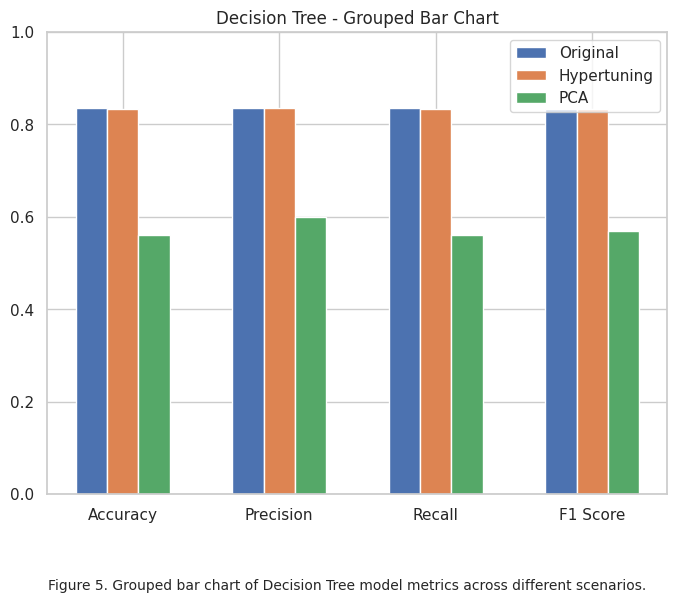

Decision Tree Results


,Scenario,Accuracy,Precision,Recall,F1 Score,Best Params
0,Original,0.8350,0.836314,0.8350,0.834340,default
1,Hypertuning,0.8325,0.834970,0.8325,0.832445,"{'max_depth': 10, 'min_samples_split': 5}"
2,PCA,0.5600,0.599872,0.5600,0.568935,"{'max_depth': 10, 'min_samples_split': 2}"


In [45]:
dt_df = evaluate_model("Decision Tree", model_defs["Decision Tree"]["model"], model_defs["Decision Tree"]["params"])
plot_bar_chart(dt_df, "Decision Tree", fig_num=5, caption="Grouped bar chart of Decision Tree model metrics across different scenarios.")
print("Decision Tree Results")
display(dt_df)


## Step 8.2: K-Nearest Neighbors (KNN) – Radar Chart
Evaluate the KNN model and visualize the results using a radar chart.

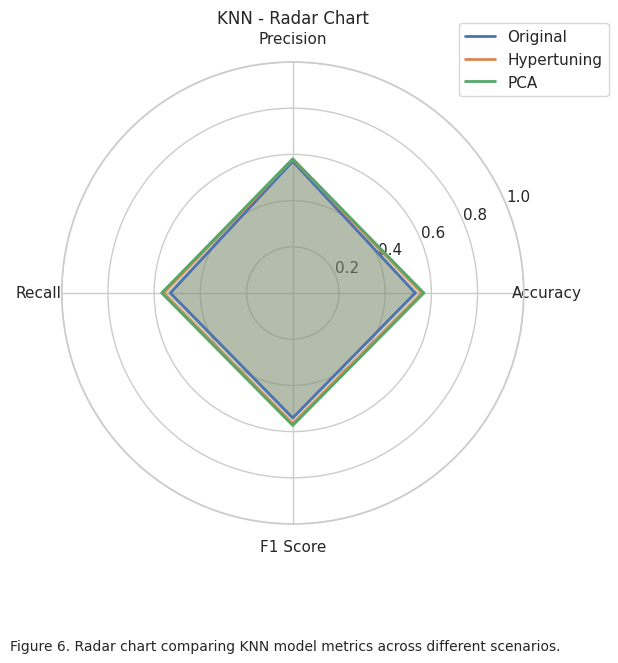

KNN Results


,Scenario,Accuracy,Precision,Recall,F1 Score,Best Params
0,Original,0.5300,0.569762,0.5300,0.540707,default
1,Hypertuning,0.5600,0.578638,0.5600,0.567127,"{'n_neighbors': 7, 'weights': 'distance'}"
2,PCA,0.5675,0.581111,0.5675,0.573357,"{'n_neighbors': 7, 'weights': 'distance'}"


In [47]:
knn_df = evaluate_model("KNN", model_defs["KNN"]["model"], model_defs["KNN"]["params"])
plot_radar_chart(knn_df, "KNN", fig_num=6, caption="Radar chart comparing KNN model metrics across different scenarios.")
print("KNN Results")
display(knn_df)

## Step 8.3: Naive Bayes – Dot (Strip) Plot
Evaluate the Naive Bayes model and visualize the results using a dot (strip) plot.

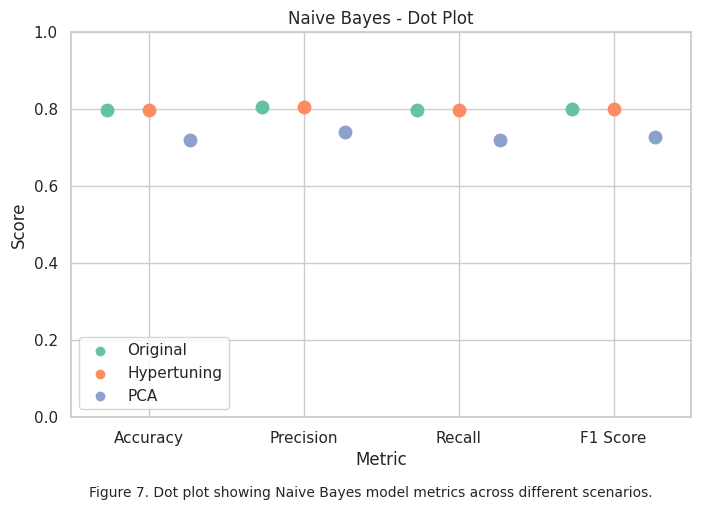

Naive Bayes Results


,Scenario,Accuracy,Precision,Recall,F1 Score,Best Params
0,Original,0.7975,0.806132,0.7975,0.799422,default
1,Hypertuning,0.7975,0.806132,0.7975,0.799422,{}
2,PCA,0.7200,0.739313,0.7200,0.726216,{}


In [49]:
nb_df = evaluate_model("Naive Bayes", model_defs["Naive Bayes"]["model"], model_defs["Naive Bayes"]["params"])
plot_dot_chart(nb_df, "Naive Bayes", fig_num=7, caption="Dot plot showing Naive Bayes model metrics across different scenarios.")
print("Naive Bayes Results")
display(nb_df)

## Step 8.4: Random Forest – Area Chart
Evaluate the Random Forest model and visualize the results using an area chart.

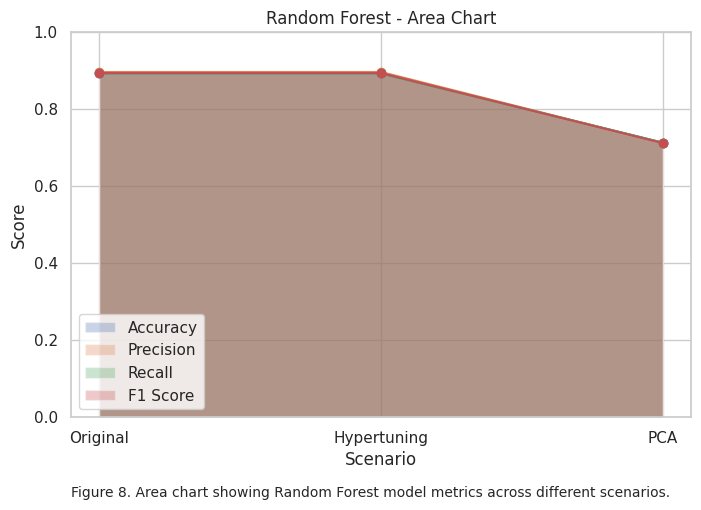

Random Forest Results


,Scenario,Accuracy,Precision,Recall,F1 Score,Best Params
0,Original,0.8925,0.896138,0.8925,0.893340,default
1,Hypertuning,0.8925,0.896138,0.8925,0.893340,"{'max_depth': None, 'n_estimators': 100}"
2,PCA,0.7125,0.711666,0.7125,0.711206,"{'max_depth': None, 'n_estimators': 100}"


In [51]:
rf_df = evaluate_model("Random Forest", model_defs["Random Forest"]["model"], model_defs["Random Forest"]["params"])
plot_area_chart(rf_df, "Random Forest", fig_num=8, caption="Area chart showing Random Forest model metrics across different scenarios.")
print("Random Forest Results")
display(rf_df)

## Step 8.5: Logistic Regression – Horizontal Bar Chart
Evaluate the Logistic Regression model and visualize the results using a horizontal bar chart.

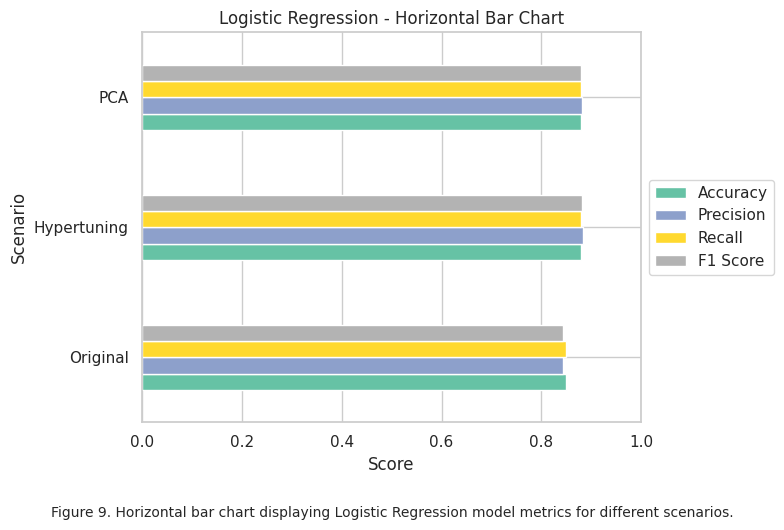

Logistic Regression Results


,Scenario,Accuracy,Precision,Recall,F1 Score,Best Params
0,Original,0.85,0.843140,0.85,0.842982,default
1,Hypertuning,0.88,0.883297,0.88,0.880969,"{'C': 10, 'penalty': 'l1'}"
2,PCA,0.88,0.881486,0.88,0.880138,"{'C': 10, 'penalty': 'l1'}"


In [53]:
lr_df = evaluate_model("Logistic Regression", model_defs["Logistic Regression"]["model"], model_defs["Logistic Regression"]["params"])
plot_horizontal_bar_chart(lr_df, "Logistic Regression", fig_num=9, caption="Horizontal bar chart displaying Logistic Regression model metrics for different scenarios.")
print("Logistic Regression Results")
display(lr_df)

## Step 9: Final Consolidated Results Table
Combine results from all models into a single DataFrame for comparison, display, and save.

In [22]:
final_df = pd.concat([
    dt_df.assign(Model="Decision Tree"),
    knn_df.assign(Model="KNN"),
    nb_df.assign(Model="Naive Bayes"),
    rf_df.assign(Model="Random Forest"),
    lr_df.assign(Model="Logistic Regression")
])[["Model", "Scenario"] + metrics + ["Best Params"]]

final_df.reset_index(drop=True, inplace=True)
print(" Final Results Table:")
display(final_df)

final_df.to_csv("all_model_results.csv", index=False)


 Final Results Table:


,Model,Scenario,Accuracy,Precision,Recall,F1 Score,Best Params
0,Decision Tree,Original,0.8350,0.836314,0.8350,0.834340,default
1,Decision Tree,Hypertuning,0.8325,0.834970,0.8325,0.832445,"{'max_depth': 10, 'min_samples_split': 5}"
2,Decision Tree,PCA,0.5600,0.599872,0.5600,0.568935,"{'max_depth': 10, 'min_samples_split': 2}"
3,KNN,Original,0.5300,0.569762,0.5300,0.540707,default
4,KNN,Hypertuning,0.5600,0.578638,0.5600,0.567127,"{'n_neighbors': 7, 'weights': 'distance'}"
5,KNN,PCA,0.5675,0.581111,0.5675,0.573357,"{'n_neighbors': 7, 'weights': 'distance'}"
6,Naive Bayes,Original,0.7975,0.806132,0.7975,0.799422,default
7,Naive Bayes,Hypertuning,0.7975,0.806132,0.7975,0.799422,{}
8,Naive Bayes,PCA,0.7200,0.739313,0.7200,0.726216,{}
9,Random Forest,Original,0.8925,0.896138,0.8925,0.893340,default


## Step 10: Confusion Matrix for Best Models
Visualize confusion matrices for the hypertuned Random Forest and Logistic Regression models to better understand the classification errors.


 Confusion Matrix - Random Forest (Hypertuned)


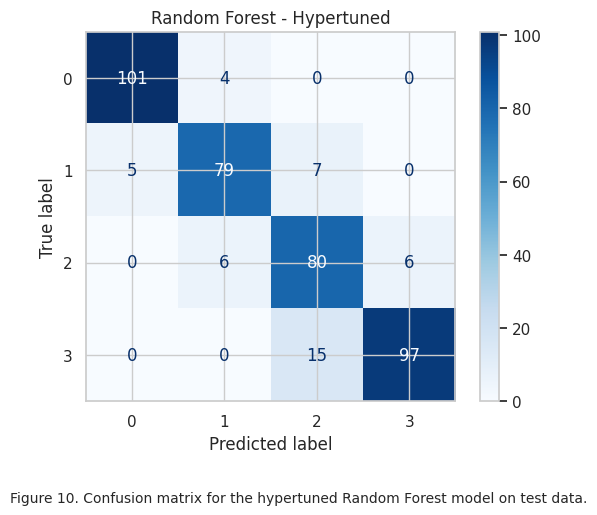


 Confusion Matrix - Logistic Regression (Hypertuned)


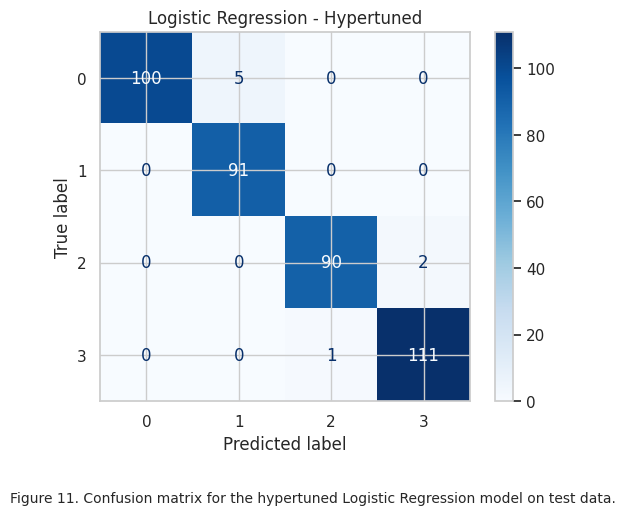

In [54]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_conf_matrix(model, X_test, y_test, title, fig_num=None, caption=""):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(title)
    
    if fig_num is not None:
        plt.figtext(0.5, -0.1, f"Figure {fig_num}. {caption}",
                    wrap=True, horizontalalignment='center', fontsize=10)
    
    plt.show()

# Random Forest Hypertuned
print("\n Confusion Matrix - Random Forest (Hypertuned)")
rf_params = rf_df.loc[rf_df['Scenario'] == 'Hypertuning', 'Best Params'].values[0]
rf_model = RandomForestClassifier(**rf_params, random_state=42)
rf_model.fit(X_train_scaled, y_train)
plot_conf_matrix(
    rf_model, X_test_scaled, y_test, 
    "Random Forest - Hypertuned",
    fig_num=10,
    caption="Confusion matrix for the hypertuned Random Forest model on test data."
)

# Logistic Regression Hypertuned
print("\n Confusion Matrix - Logistic Regression (Hypertuned)")
lr_params = final_df[(final_df['Model'] == 'Logistic Regression') & 
                    (final_df['Scenario'] == 'Hypertuning')]['Best Params'].values[0]
lr_model = LogisticRegression(**lr_params, solver='saga', max_iter=5000, random_state=42)
lr_model.fit(X_train_scaled, y_train)
plot_conf_matrix(
    lr_model, X_test_scaled, y_test, 
    "Logistic Regression - Hypertuned",
    fig_num=11,
    caption="Confusion matrix for the hypertuned Logistic Regression model on test data."
)


## Step 11: SHAP Interpretability for Random Forest
Use SHAP to explain feature importance and contribution for the hypertuned Random Forest model predictions.


 SHAP Summary - Random Forest (Hypertuned)


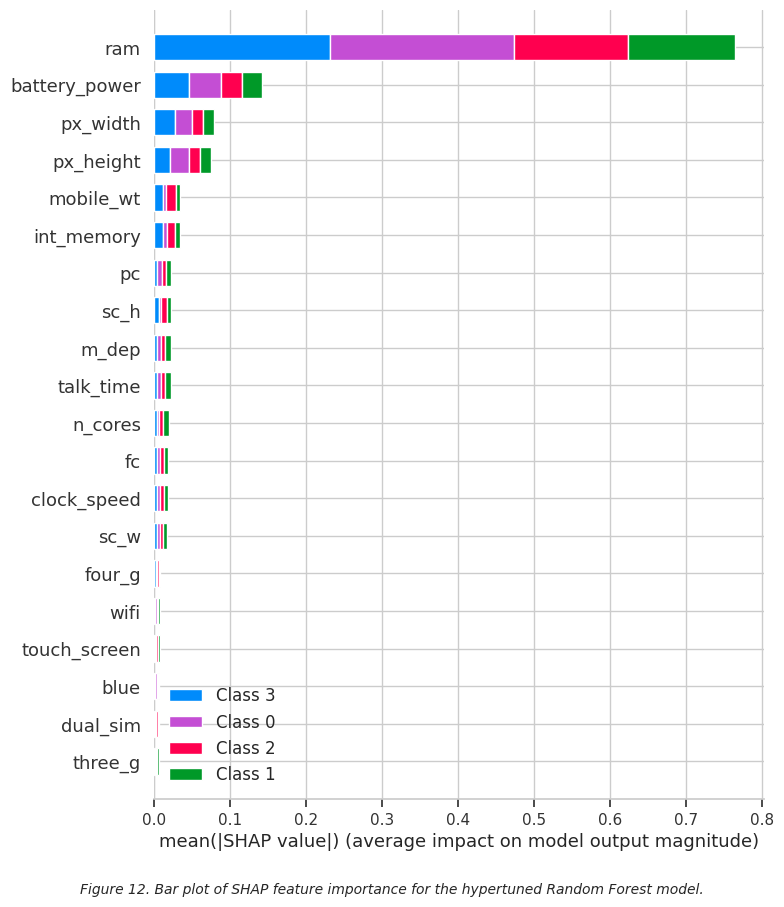

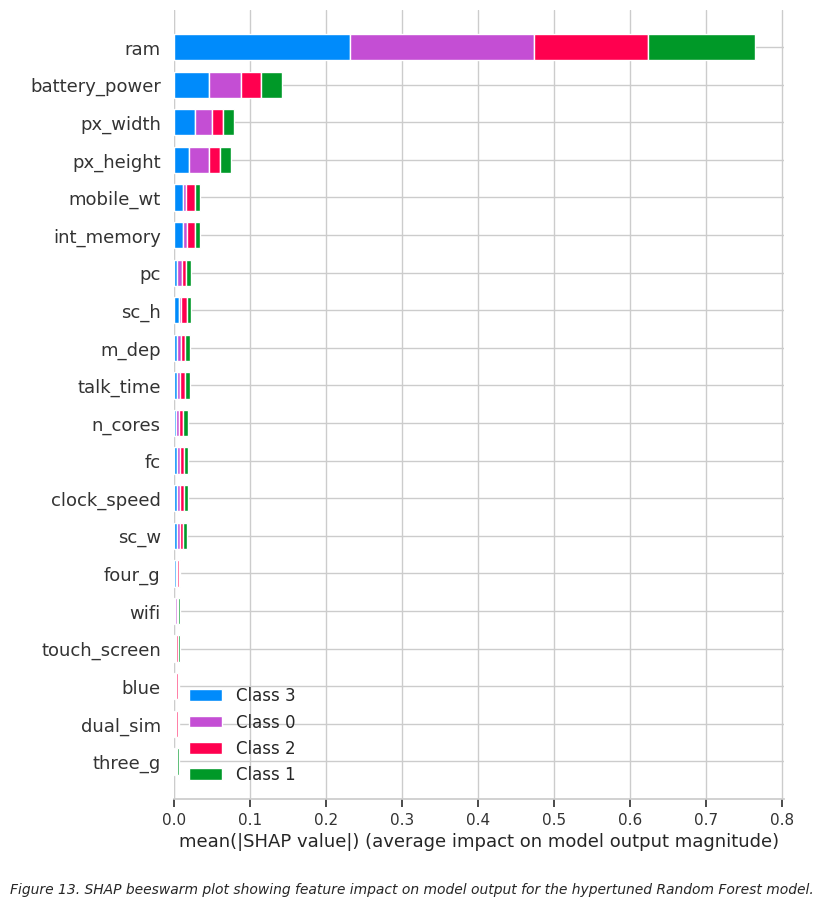

In [57]:
import matplotlib.pyplot as plt
import shap

print("\n SHAP Summary - Random Forest (Hypertuned)")
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test_scaled)

def add_apa_caption(fig, fig_num, caption):
    # Add some space at the bottom for the caption
    fig.subplots_adjust(bottom=0.15)  # increase bottom margin
    # Add caption at the bottom inside the figure area
    fig.text(0.5, 0.05, f"Figure {fig_num}. {caption}", ha='center', fontsize=10, style='italic')

# Figure 12: Bar plot of feature importance
fig1 = plt.figure()
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
add_apa_caption(fig1, 12, "Bar plot of SHAP feature importance for the hypertuned Random Forest model.")
plt.show()

# Figure 13: Detailed SHAP summary plot (beeswarm)
fig2 = plt.figure()
shap.summary_plot(shap_values, X_test, show=False)
add_apa_caption(fig2, 13, "SHAP beeswarm plot showing feature impact on model output for the hypertuned Random Forest model.")
plt.show()


###  Best Model Selection: Random Forest (Hypertuned)

After evaluating all models across different scenarios (Original, Hypertuned, and PCA), the **Random Forest (Hypertuned)** model emerges as the best performer.

#### Performance Metrics:
- **Accuracy:** 0.8925  
- **Precision:** 0.8961  
- **Recall:** 0.8925  
- **F1 Score:** 0.8933  
- **Best Parameters:** `{'max_depth': None, 'n_estimators': 100}`

####  Why Random Forest is the Best:
- **Highest overall performance** across all evaluation metrics.
- **Consistent results** between original and hypertuned versions, indicating robustness and stability.
- **Balanced precision, recall, and F1-score**, meaning the model handles all classes well without bias.
- As an **ensemble model**, Random Forest reduces overfitting and generalizes better by averaging multiple decision trees.
- Performs well even without dimensionality reduction (PCA), unlike other models that degrade significantly after PCA.

####  Comparison Highlights:
| Model                 | Accuracy (Best Case) | Notes |
|-----------------------|----------------------|-------|
| **Random Forest**     | **0.8925**            | Best overall performance |
| Logistic Regression   | 0.8800               | Strong performance, but slightly lower |
| Naive Bayes           | 0.7975               | Decent, but less reliable |
| Decision Tree         | 0.8350               | Good, but not as accurate |
| KNN                   | 0.5675               | Weak performance overall |

#### Conclusion

In this project, we explored the Mobile Price Classification dataset using a complete machine learning pipeline from data preprocessing and exploratory data analysis (EDA) to model training, tuning, evaluation, and interpretability. We implemented five classification algorithms: Decision Tree, K-Nearest Neighbors (KNN), Random Forest, Naive Bayes, and Logistic Regression. Each model was evaluated across three scenarios: original, hypertuned using GridSearchCV, and after applying dimensionality reduction through PCA.

Among all models, the **Random Forest (Hypertuned)** stood out as the best performer. It achieved the highest accuracy (0.8925), precision, recall, and F1-score, indicating it not only makes correct predictions but also balances false positives and false negatives effectively. This model’s consistency across both original and tuned versions also highlights its robustness. Logistic Regression also performed well, especially after hypertuning, but fell slightly short of Random Forest in overall performance.

Interestingly, some models like Decision Tree and KNN showed noticeable drops in performance after PCA, while Naive Bayes was relatively stable. These results emphasize that not all models benefit from dimensionality reduction, and model choice must consider both the data structure and algorithm characteristics.

Overall, this project demonstrates the power of ensemble methods like Random Forest in structured classification tasks. By combining model performance with SHAP-based explainability, we not only identified the most accurate model but also gained insights into which features (like RAM, battery power, and internal memory) play the biggest roles in predicting price range. This workflow can be applied to similar classification problems in real-world scenarios, especially when product segmentation or pricing decisions are involved.
